# How to Build Machine Learning Pipelines And Track Experiments with DVC Inside VSCode
## Manage ML experiments like a pro


### Why track experiments?

Keeping track of machine learning experiments is like trying to keep FIVE dogs in a bathtub. Without help, at least FOUR of them are bound to slip out of your hands and ruin everything. 

A total disaster is what's going to happen if you don't have a proper experiment management system. First, you'll probably end up with a complete mess of code, with no idea which version of the model is the most recent or the best performing. You'll be constantly overwriting and losing important code, and it will be almost impossible to reproduce your results or track your progress.

On top of that, you'll have no way of keeping track of hyperparameters, metrics, or any other important details of your experiments (unless you want to write them down😱). You'll be flying blind.

But hey, at least you'll have a lot of fun trying to untangle the mess you've created! Nothing like wasting countless hours trying to figure out what went wrong, right?

In all seriousness, a proper experiment management system is crucial for any machine learning project. It allows you to track and compare your experiments, reproduce results, and make informed decisions about the direction of your project. Without it, you're just shooting in the dark and hoping for the best.

### What you will learn in this tutorial

### Project setup

Start by forking [the following GitHub repository](https://github.com/BexTuychiev/dvc-tutorial), cloning the `experiments` branch and opening the project with VSCode:

```
$ git clone --branch experiments https://github.com/YourUsername/dvc-tutorial.git dvc-tutorial
$ cd dvc-tutorial
$ code .
```

The cloned repository only contains a single `train.py` inside the `src` directory and the `requirements.txt` file. Install its contents inside a virtual environment, preferably `conda`:

```
$ conda create -n dvc-tutorial python==3.9 -y
$ conda activate dvc-tutorial
$ python -r requirements.txt
```

Now, you can initialize DVC and download the dataset:

```
$ dvc init
$ dvc get REMOTE_LINK # To be added later
```

The `get` command will download a `data` directory, which you should track with DVC and:

```
$ dvc add data
```

Afterwards, our project tree should resemble the following structure:

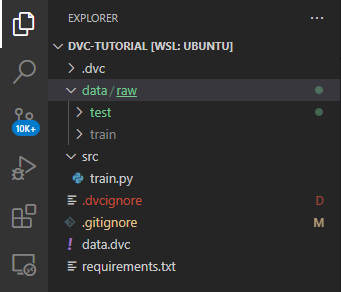

The `train` and `test` folders contain images with varying sizes from the [German Traffic Signs Recognition Benchmark dataset](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign). There are 43 classes of traffic signs and over 40k images.

Let's commit the changes:

```
$ git add --all
$ git commit -m "Track the dataset with DVC"
```

You should also install the [DVC VSCode extension](https://marketplace.visualstudio.com/items?itemName=Iterative.dvc) from the marketplace as it is the main focus of our tutorial:

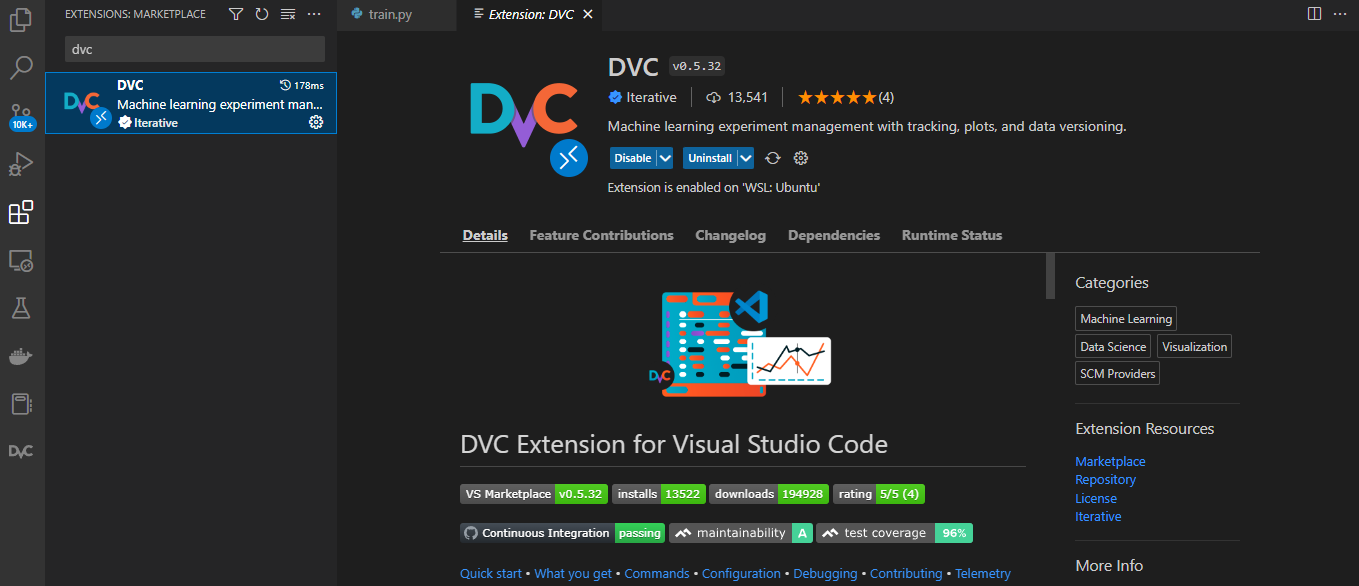

Once the extension is correctly set up, it should automatically detect DVC-enabled directories in your projects. If you see an empty circle on the bottom left (instead of a red cross inside), everything is working as expected:



> Windows users might have a problem the extension, mainly when it tries to detect DVC-enabled repositories. If you are unable to resolve the issues, I suggest installing the WSL2 Ubuntu distribution on your machine (like I did). You can read my step-by-step tutorial on the topic from Medium [here](https://medium.com/towards-data-science/how-to-create-perfect-machine-learning-development-environment-with-wsl2-on-windows-10-11-2c80f8ea1f31).

### Running experiments with DVC and VSCode extension

In machine learning, a single run of a training script (or a chain of scripts) is called an experiment. A typical training script trains a single machine learning, and saves them to the disk. The script also reports the exact hyperparameters of the model and one or more metrics to quantify the model's performance.

> A hyperparameter is a user-defined "settings" of a model. For example, a popular Random Forest model has a `n_estimators` parameter that controls the number of trees built inside the ensemble.

Currently, our `src/train.py` does not perform any of the listed tasks. But we can add that functionality with a single line of code using the DVCLive 

SHOW HOW TO ADD THE DVCLIVE EXTENSION

THEN SHOW HOW TO RUN THE CURRENT SCRIPT WITH VSCODE

SHOW A GIF AS THE EXPERIMENT RUNS